## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
import tensorflow as tf
import keras
import numpy as np
from keras import backend as K
from keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Do one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# 超參數設定
batch_size = 64
epochs = 20
num_classes = 10
lr = 1e-3

In [4]:
# 以 ResNet50 為基礎來建立模型，
mod_basic = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(x_train.shape[1],x_train.shape[2],3)) # 輸入訓練的影像size 32*32
# 捨棄 ResNet50 頂層的 fully connected layers
x = mod_basic.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(num_classes,activation='softmax', name='softmax')(x)

model=Model(inputs=mod_basic.input, outputs=output_layer)
model.summary()

model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', metrics=['accuracy'])

D:\Users\Mu\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [5]:
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [6]:
history = model.fit_generator(augment_generator.flow(x_train,y_train,batch_size=batch_size),
                            steps_per_epoch=int(len(x_train)/batch_size),
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test,verbose=0)

print("Test loss:", score[0])
print("Test accuracy", score[1])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/20
781/781 [==============================] - 165s 212ms/step - loss: 3.3252 - accuracy: 0.1621 - val_loss: 16.7112 - val_accuracy: 0.1451
Epoch 2/20
781/781 [==============================] - 140s 179ms/step - loss: 2.1415 - accuracy: 0.2733 - val_loss: 2.6347 - val_accuracy: 0.4203
Epoch 3/20
781/781 [==============================] - 140s 180ms/step - loss: 1.7863 - accuracy: 0.3934 - val_loss: 1.9810 - val_accuracy: 0.5240
Epoch 4/20
781/781 [==============================] - 140s 179ms/step - loss: 1.5224 - accuracy: 0.4840 - val_loss: 1.4532 - val_accuracy: 0.5830
Epoch 5/20
781/781 [==============================] - 140s 179ms/step - loss: 1.3377 - accuracy: 0.5439 - val_loss: 1.2510 - val_accuracy: 0.6257
Epoch 6/20
781/781 [==============================] - 140s 179ms/step - loss: 1.2016 - accuracy: 0.5914 - val_loss: 1.1008 - val_accuracy: 0.6590
Epoch 7/20
781/781 [==============================] - 140s 179ms/step - loss: 1.0990 - accuracy: 0.6250 - val_loss: 0.9852 

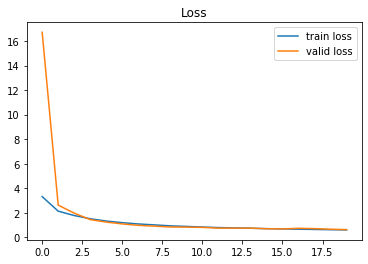

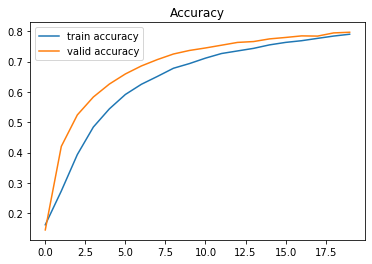

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()